# 1. Download, read and pre-process the data of Elasticity

In [ ]:
# download the database
from pymatgen.ext.matproj import MPRester
import shelve

m = MPRester(" ") # the API key of your Materials Project account
data = m.query(criteria={"has": "elasticity"}, properties=["task_id", "pretty_formula", "elements","structure", "elasticity"])
tempShelf = shelve.open('data_materials_elasticity')
tempShelf['data'] = data
tempShelf.close()

In [2]:
# open the database
import shelve
tempShelf = shelve.open('data_materials_elasticity')
data = tempShelf['data']
tempShelf.close()

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data)
#df.to_hdf('data_materials_elasticity.h5',key='df', mode='w')
df_el = df['elasticity'].apply(pd.Series)
df_full = pd.concat([df[['task_id', 'pretty_formula', 'elements', 'structure']], 
                     df_el['elastic_tensor'].apply(np.array)], axis=1)
df_full_clean = df_full.dropna(axis=0, how='any')
# delete Ne,He and Ar which are not crystals
df_full_clean = df_full_clean.drop(index=[1065,11663,12669],axis=0)
#df_full_clean[df_full_clean['pretty_formula'].str.contains('Ne', case=True)]

In [15]:
# extract the independent components of elastic tensor array
mask_1d = np.flatnonzero(np.triu(np.ones((6,6))))
el_series_flatten = df_full_clean['elastic_tensor'].apply(np.ravel)
el_series_flatten_independent = el_series_flatten.apply(np.take, indices=mask_1d)
el_t = el_series_flatten_independent.to_list()
el_t_arr = np.array(el_t)
el_t_arr.shape

# 2 Models to predicit elastic tensor from composition

## 2.1 generate the dataset

### 2.1.1 featurizer ElementPropertyFingerprint(EPF)

In [22]:
import pymatgen.core as mg
import deepchem as dc

# generate the dataset
comps = df_full_clean['pretty_formula'].to_list()
featurizer_comps = dc.feat.ElementPropertyFingerprint()
features_comps = featurizer_comps.featurize(comps)
dataset_comps_EPF = dc.data.NumpyDataset(X=features_comps, y=el_t_arr, ids=np.array(comps))

In [127]:
splitter = dc.splits.RandomSplitter()
train_comps, valid_comps, test_comps = splitter.train_valid_test_split(dataset_comps_EPF, 
                                                                       frac_train=0.5, 
                                                                       frac_valid=0.3, 
                                                                       frac_test=0.2)

### 2.1.2 ElementNetFeaturizer(ENF)

In [ ]:
featurizer_comps = dc.feat.ElemNetFeaturizer()
features_comps = featurizer_comps.featurize(comps)
features_comps.shape
#np.isnan(features_comps).any()
dataset_comps_ENF = dc.data.NumpyDataset(X=features_comps, y=el_t_arr, ids=np.array(comps))
dataset_comps_ENF.to_dataframe().describe()  

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,y13,y14,y15,y16,y17,y18,y19,y20,y21,w
count,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,...,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.0
mean,0.010877,0.025867,0.007084,0.014455,0.016887,0.024455,0.093463,0.023184,0.011558,0.022916,...,-0.026881,0.080948,-0.000683,45.173514,-0.003113,0.085048,45.479611,0.008353,47.449465,1.0
std,0.079178,0.103863,0.063024,0.085411,0.087326,0.104637,0.211518,0.120159,0.068270,0.101790,...,1.767992,3.761694,0.997681,93.781238,0.734338,3.364735,93.905223,4.179441,94.466886,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-106.000000,-99.000000,-37.000000,-7750.000000,-24.000000,-58.000000,-7750.000000,-142.000000,-7750.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,17.000000,0.000000,19.000000,1.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,37.000000,0.000000,0.000000,37.000000,0.000000,40.000000,1.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,68.000000,0.000000,0.000000,68.000000,0.000000,70.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,33.000000,84.000000,47.000000,3302.000000,24.000000,204.000000,3302.000000,102.000000,3302.000000,1.0


In [84]:
splitter = dc.splits.RandomSplitter()
train_comps, valid_comps, test_comps = splitter.train_valid_test_split(dataset_comps_ENF, 
                                                                       frac_train=0.8, 
                                                                       frac_valid=0.1, 
                                                                       frac_test=0.1)

## 2.2 Build, train and evaluate the model

In [93]:
import torch

pytorch_model = torch.nn.Sequential(
    torch.nn.Linear(65, 65),
    torch.nn.Tanh(),
    torch.nn.Linear(65, 32),
    torch.nn.Tanh(),
    torch.nn.Linear(32, 21)
)
model = dc.models.TorchModel(pytorch_model, dc.models.losses.L2Loss(),batch_size=100,learning_rate=0.0005)
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
model.fit(train_comps, nb_epoch=200)
print('training set score:', model.evaluate(train_comps, [metric],per_task_metrics=True))
print('test set score:', model.evaluate(test_comps, [metric]))

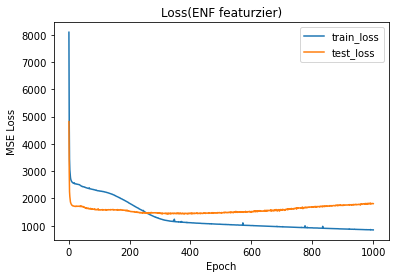

In [90]:
# plot the loss-Epoch
import matplotlib.pyplot as plt

epoch_list = np.linspace(1,num_epochs,num_epochs)
plt.plot(epoch_list, 
         train_loss, 
         '-', 
         label = 'train_loss')
plt.plot(epoch_list, 
         test_loss, 
         '-', 
         label = 'test_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss(ENF featurzier)')
plt.legend()
plt.savefig('ENF1.jpg')

In [92]:
import matplotlib.pyplot as plt

with torch.no_grad():
    Y_pred = m(X_test).numpy()
Y_true = Y_test.numpy()

for i in range(22):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1 - np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'Y{i+1}, R^2={R_2:.4f}')
    plt.savefig(f'results/Elasticity_EPF/Y{i+1}')
    plt.show()

# 3. construct a model for crystal structure and composition(CGCNN)

## 3.1 generate the dataset

In [ ]:
featurizer_struct = dc.feat.CGCNNFeaturizer()
struct_list = df_full_clean['structure'].to_list()
features_struct = featurizer_struct.featurize(struct_list)
dataset_struct_CG = dc.data.NumpyDataset(X=features_struct, y=el_t_arr, ids=np.array(comps))

In [164]:
#transform the dataset
#transformer = []
#transformer = dc.trans.NormalizationTransformer(transform_y=True,dataset = dataset_struct_CG)
#transformer = dc.trans.MinMaxTransformer(transform_y=True, dataset = dataset_struct_CG)
#dataset_struct_CG = transformer.transform(dataset_struct_CG)

#split the dataset
train_struct, valid_struct, test_struct = splitter.train_valid_test_split(dataset_struct_CG, 
                                                                          frac_train=0.6,
                                                                          frac_valid=0.3,
                                                                          frac_test=0.1)

## 3.2 Build, train and evaluate the model

In [167]:
model = dc.models.CGCNNModel(mode='regression', n_tasks=21, batch_size=32, learning_rate=0.001)

#train the model

train_loss = []
valid_loss = []

#metric = dc.metrics.Metric(dc.metrics.r2_score)
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
for i in range(10):
    model.fit(train_struct, nb_epoch=1)

#evaluate the model
    train_loss.append(model.evaluate(train_struct, [metric])['mean_squared_error'])
    valid_loss.append(model.evaluate(valid_struct, [metric])['mean_squared_error'])
    print("Train loss:", model.evaluate(train_struct, [metric]))
    print("Valid loss:", model.evaluate(valid_struct, [metric]))
   

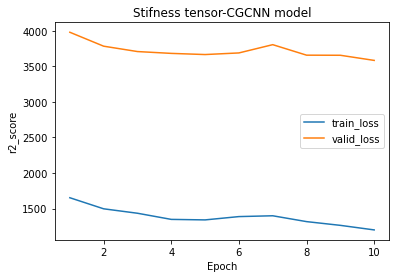

In [158]:
# plot loss-Epoch
epoch_list = np.linspace(1,10,10)
plt.plot(epoch_list, 
         train_loss, 
         '-', 
         label = 'train_loss')
plt.plot(epoch_list, 
         valid_loss, 
         '-', 
         label = 'valid_loss')
plt.xlabel('Epoch')
plt.ylabel('r2_score')
plt.title('Stifness tensor-CGCNN model')
plt.legend()
plt.savefig('CGCNN3.jpg')

In [126]:
Y_true = test_struct.y
Y_pred = model.predict(test_struct)

for i in range(21):
    Y_bar = np.mean(Y_true[:,i])
    R_2 = 1-np.sum((Y_true[:,i] - Y_pred[:,i])**2) / np.sum((Y_true[:,i] - Y_bar)**2)
    plt.plot(Y_true[:, i], Y_pred[:, i], '.')
    plt.plot(Y_true[:, i], Y_true[:, i], '-')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title(f'y{i+1}, R^2={R_2:.4f}, MSE={MSE:.4f}')
    plt.savefig(f'results/Elasticity_CGCNN/y{i+1}')
    plt.show()

TypeError: 'NormalizationTransformer' object is not iterable